In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy import stats
import datetime as dt

In [25]:
# Load the dataset
df = pd.read_excel('Online Retail.xlsx') 
# Display basic information about the dataset
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None
            Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000   

In [26]:
# Check for missing values
print(df.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [27]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

In [28]:
# Convert 'InvoiceDate' to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [29]:
# Remove rows with negative quantities or prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [30]:
# Create a 'TotalAmount' column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

Top 10 Sales Days:
       InvoiceNo  StockCode                          Description  Quantity  \
540421    581483      23843          PAPER CRAFT , LITTLE BIRDIE     80995   
61619     541431      23166       MEDIUM CERAMIC TOP STORAGE JAR     74215   
222680    556444      22502       PICNIC BASKET WICKER 60 PIECES        60   
15017     537632  AMAZONFEE                           AMAZON FEE         1   
299982   A563185          B                      Adjust bad debt         1   
173382    551697       POST                              POSTAGE         1   
348325    567423      23243  SET OF TEA COFFEE SUGAR TINS PANTRY      1412   
52711     540815      21108   FAIRY CAKE FLANNEL ASSORTED COLOUR      3114   
160546    550461      21108   FAIRY CAKE FLANNEL ASSORTED COLOUR      3114   
421601    573003      23084                   RABBIT NIGHT LIGHT      2400   

               InvoiceDate  UnitPrice  CustomerID         Country  TotalAmount  
540421 2011-12-09 09:15:00       2.08    

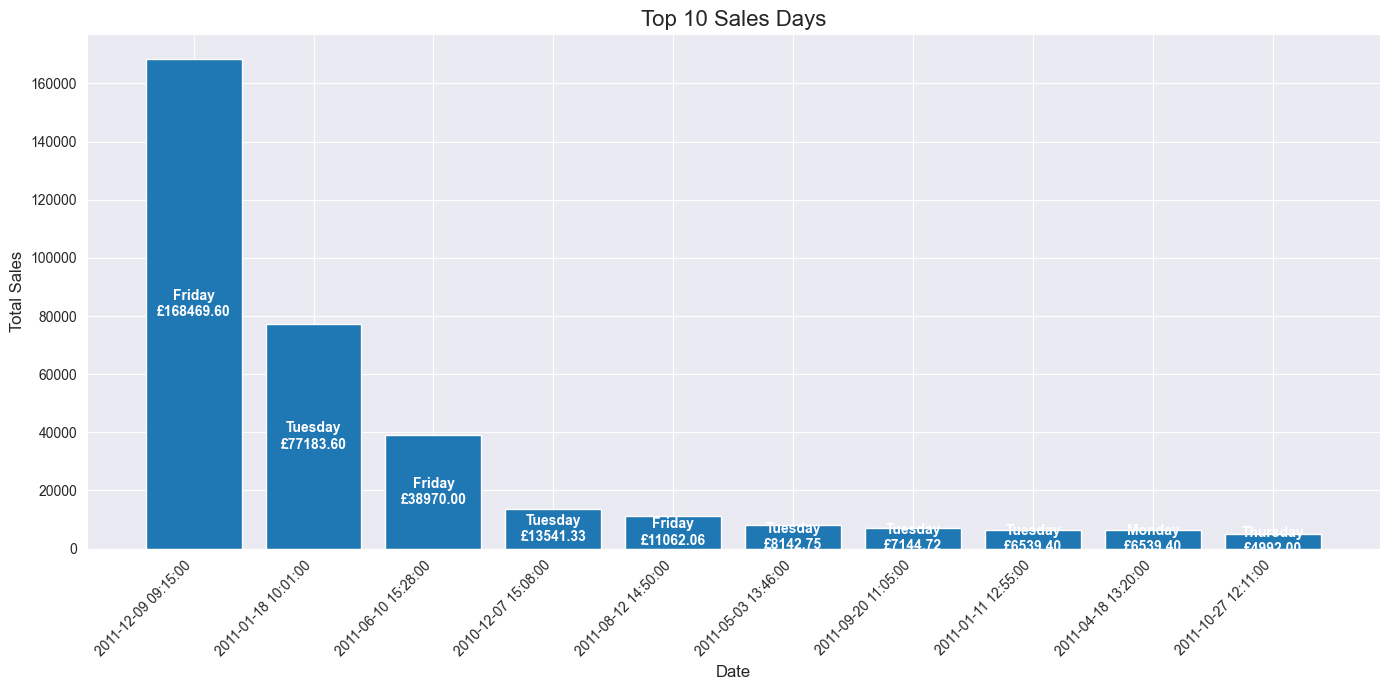

In [31]:
# Top 10 Sales Days
top_10_days = df.nlargest(10, 'TotalAmount')
print("Top 10 Sales Days:")
print(top_10_days)

top_10_days['InvoiceDate'] = pd.to_datetime(top_10_days['InvoiceDate'])

plt.figure(figsize=(14, 7))
bars = plt.bar(top_10_days['InvoiceDate'].astype(str), top_10_days['TotalAmount'])
plt.title('Top 10 Sales Days', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add day of week and sales amount inside bars
for bar, date, sales in zip(bars, top_10_days['InvoiceDate'], top_10_days['TotalAmount']):
    day_of_week = date.day_name()
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, 
             f'{day_of_week}\n£{sales:.2f}', 
             ha='center', va='center', 
             fontweight='bold', color='white')

plt.tight_layout()
plt.show()

In [32]:
# Display the first few rows of the cleaned dataset
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalAmount  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom        15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom        22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34  


In [33]:
# Customer Purchase Patterns

In [34]:
# Aggregate data by customer
customer_summary = df.groupby('CustomerID').agg({
    'InvoiceNo': 'count',
    'TotalAmount': 'sum'
}).reset_index()

customer_summary.columns = ['CustomerID', 'OrderFrequency', 'TotalSpending']

In [35]:
# Create customer segments
customer_summary['FrequencySegment'] = pd.qcut(customer_summary['OrderFrequency'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
customer_summary['SpendingSegment'] = pd.qcut(customer_summary['TotalSpending'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

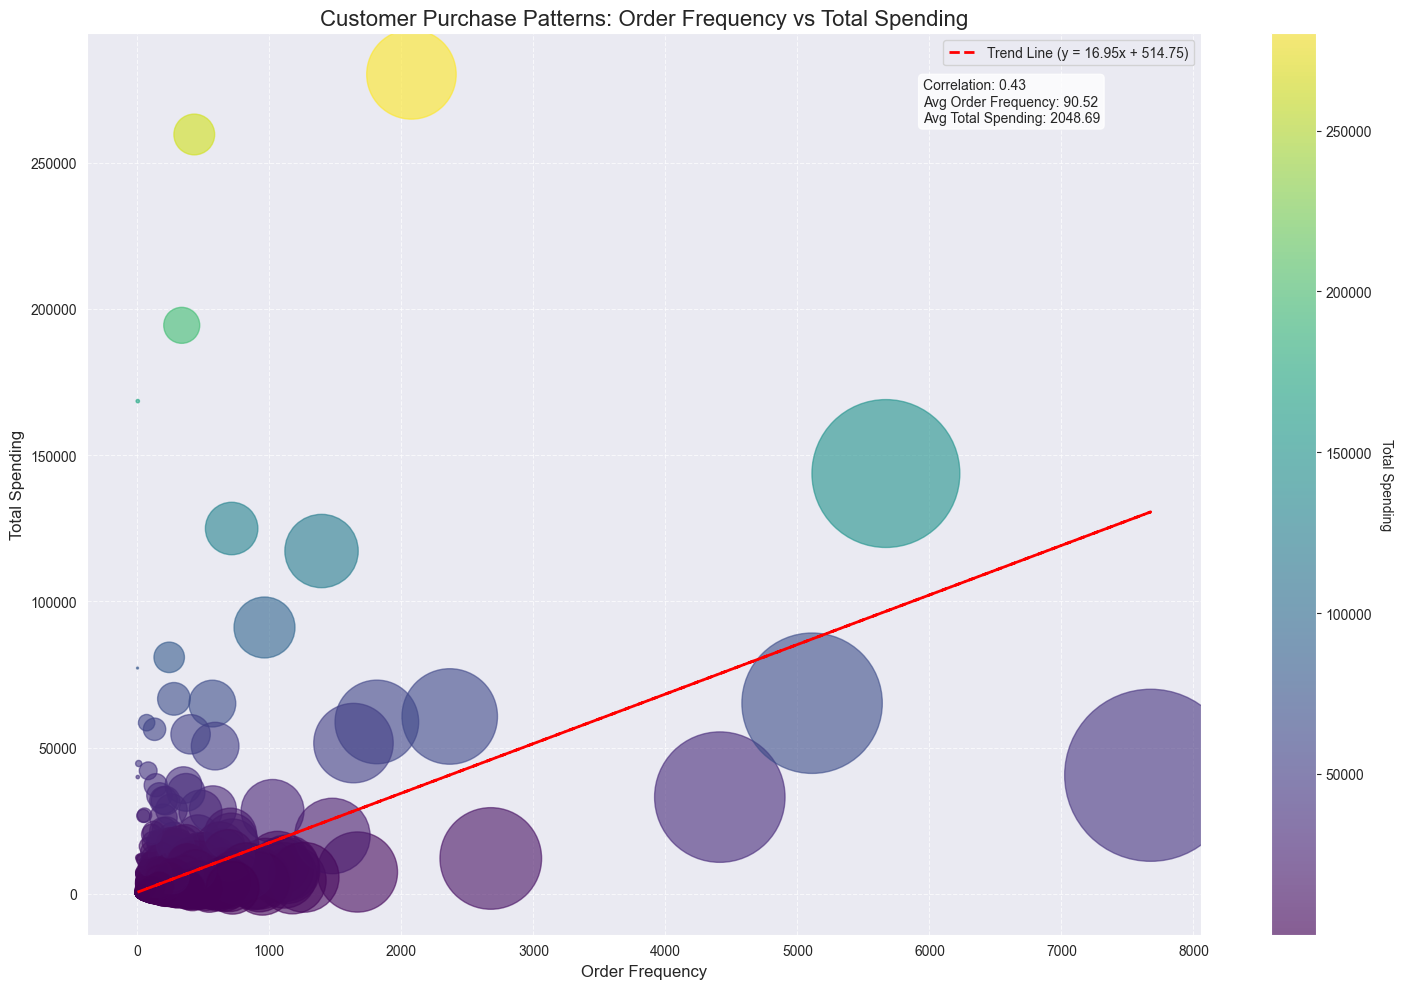

In [36]:
# Create a detailed scatter plot with improved visualization
plt.figure(figsize=(15, 10))

# Scatter plot with size and color representing different aspects
scatter = plt.scatter(
    customer_summary['OrderFrequency'], 
    customer_summary['TotalSpending'],
    c=customer_summary['TotalSpending'],  # Color based on total spending
    s=customer_summary['OrderFrequency'] * 2,  # Size based on order frequency
    alpha=0.6,
    cmap='viridis'
)

# Add color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Total Spending', rotation=270, labelpad=15)

# Add trend line
z = np.polyfit(customer_summary['OrderFrequency'], customer_summary['TotalSpending'], 1)
p = np.poly1d(z)
plt.plot(customer_summary['OrderFrequency'], 
         p(customer_summary['OrderFrequency']), 
         "r--", 
         linewidth=2, 
         label=f'Trend Line (y = {z[0]:.2f}x + {z[1]:.2f})')

# Calculate correlation and other statistics
correlation = customer_summary['OrderFrequency'].corr(customer_summary['TotalSpending'])
avg_frequency = customer_summary['OrderFrequency'].mean()
avg_spending = customer_summary['TotalSpending'].mean()

# Customize the plot
plt.title('Customer Purchase Patterns: Order Frequency vs Total Spending', fontsize=16)
plt.xlabel('Order Frequency', fontsize=12)
plt.ylabel('Total Spending', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

# Add text box with statistics
stats_text = f'Correlation: {correlation:.2f}\n'
stats_text += f'Avg Order Frequency: {avg_frequency:.2f}\n'
stats_text += f'Avg Total Spending: {avg_spending:.2f}'
plt.text(0.75, 0.95, stats_text, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


C:\Users\SURANJANA\AppData\Local\Temp\ipykernel_23440\2542881327.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_spending = customer_summary.groupby(['FrequencySegment', 'SpendingSegment'])['TotalSpending'].mean().unstack()


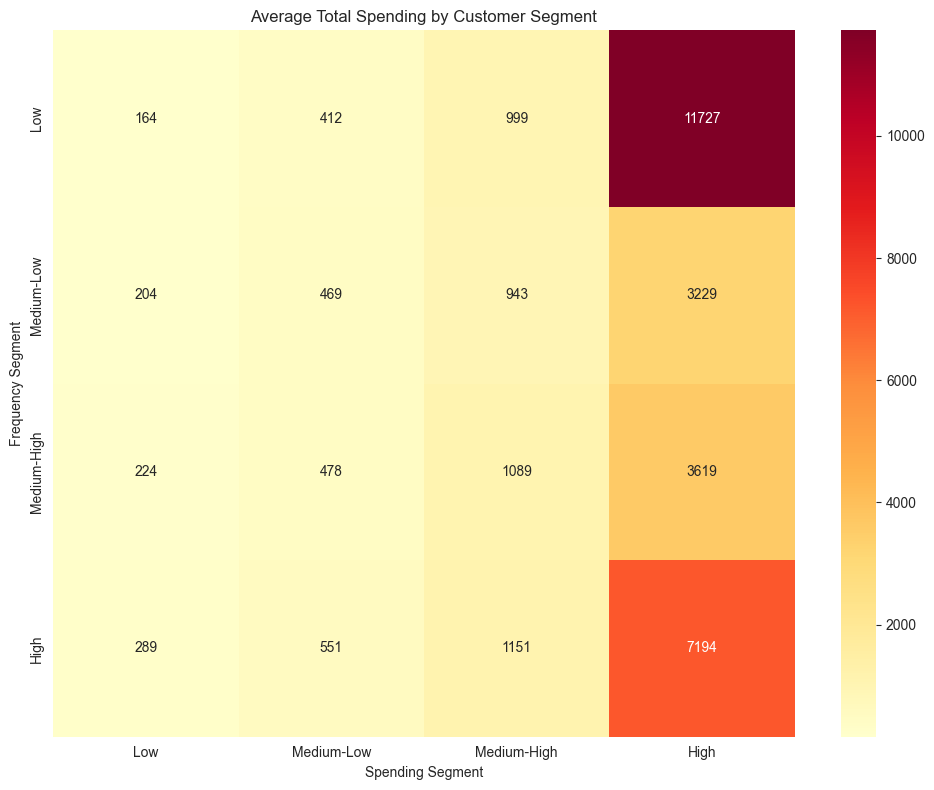

In [37]:
segment_spending = customer_summary.groupby(['FrequencySegment', 'SpendingSegment'])['TotalSpending'].mean().unstack()

plt.figure(figsize=(10, 8))
sns.heatmap(segment_spending, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Average Total Spending by Customer Segment')
plt.xlabel('Spending Segment')
plt.ylabel('Frequency Segment')
plt.tight_layout()
plt.show()

C:\Users\SURANJANA\AppData\Local\Temp\ipykernel_23440\2739591071.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_counts = customer_summary.groupby(['FrequencySegment', 'SpendingSegment']).size().unstack()


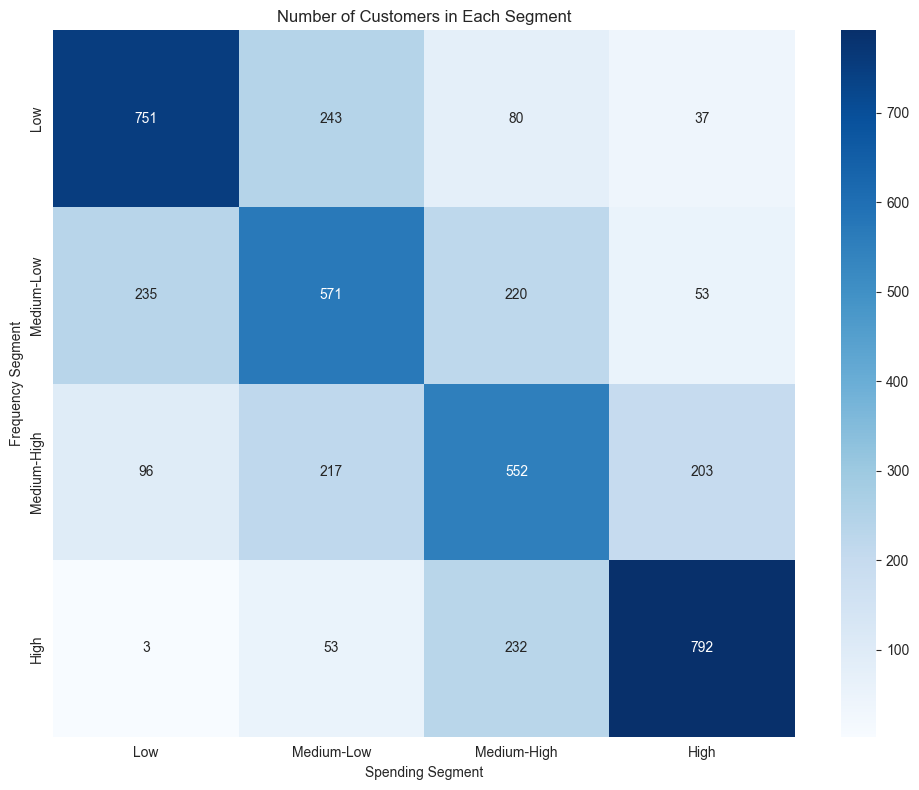

In [38]:
segment_counts = customer_summary.groupby(['FrequencySegment', 'SpendingSegment']).size().unstack()

plt.figure(figsize=(10, 8))
sns.heatmap(segment_counts, annot=True, fmt='d', cmap='Blues')
plt.title('Number of Customers in Each Segment')
plt.xlabel('Spending Segment')
plt.ylabel('Frequency Segment')
plt.tight_layout()
plt.show()

In [39]:
# Daily Sales Trends

In [40]:
# Daily sales data
df['Date'] = df['InvoiceDate'].dt.date
daily_sales = df.groupby('Date')['TotalAmount'].sum().reset_index()

# Convert 'Date' column to datetime
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])
daily_sales['DayOfWeek'] = daily_sales['Date'].dt.day_name()

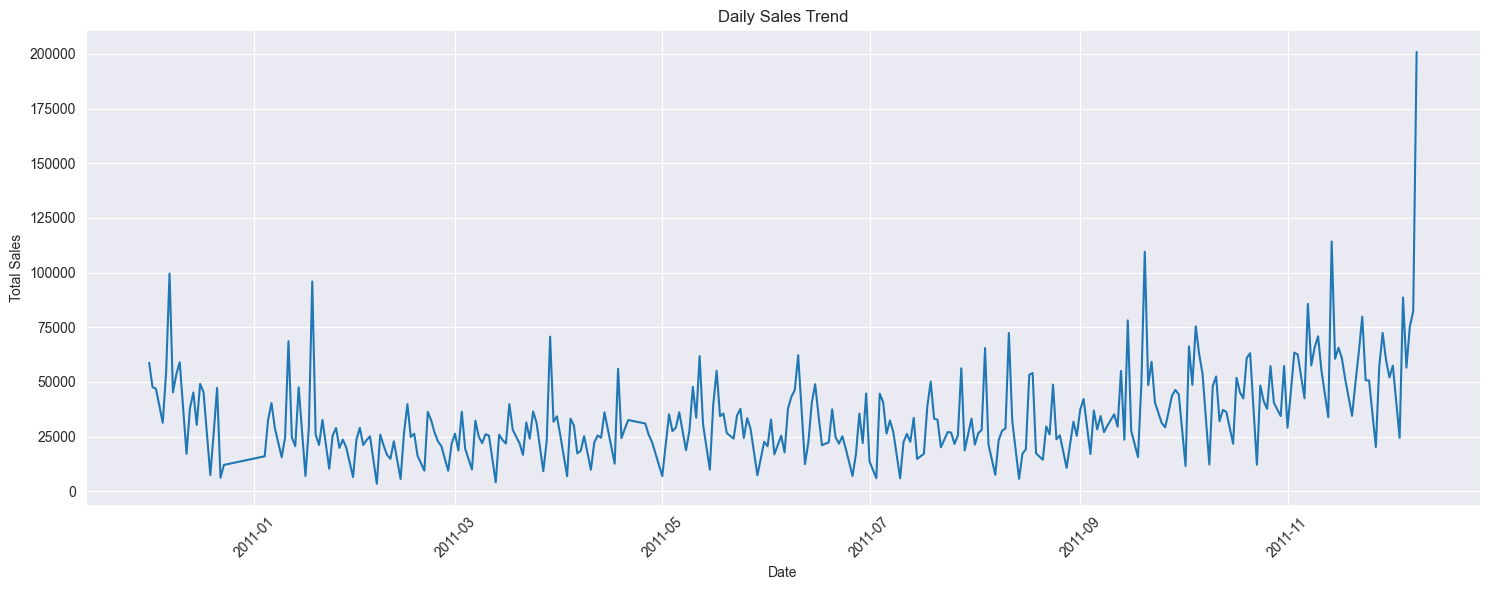

In [41]:
# Daily Sales Trend
plt.figure(figsize=(15, 6))
plt.plot(daily_sales['Date'], daily_sales['TotalAmount'])
plt.title('Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

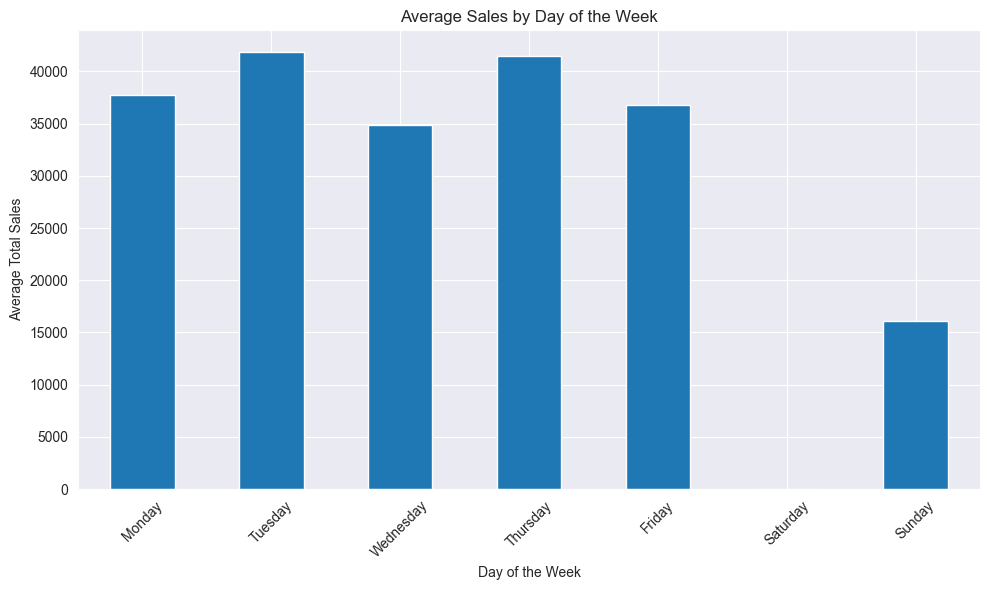

In [42]:
# Sales by Day of Week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales = daily_sales.groupby('DayOfWeek')['TotalAmount'].mean().reindex(day_order)

plt.figure(figsize=(10, 6))
weekday_sales.plot(kind='bar')
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

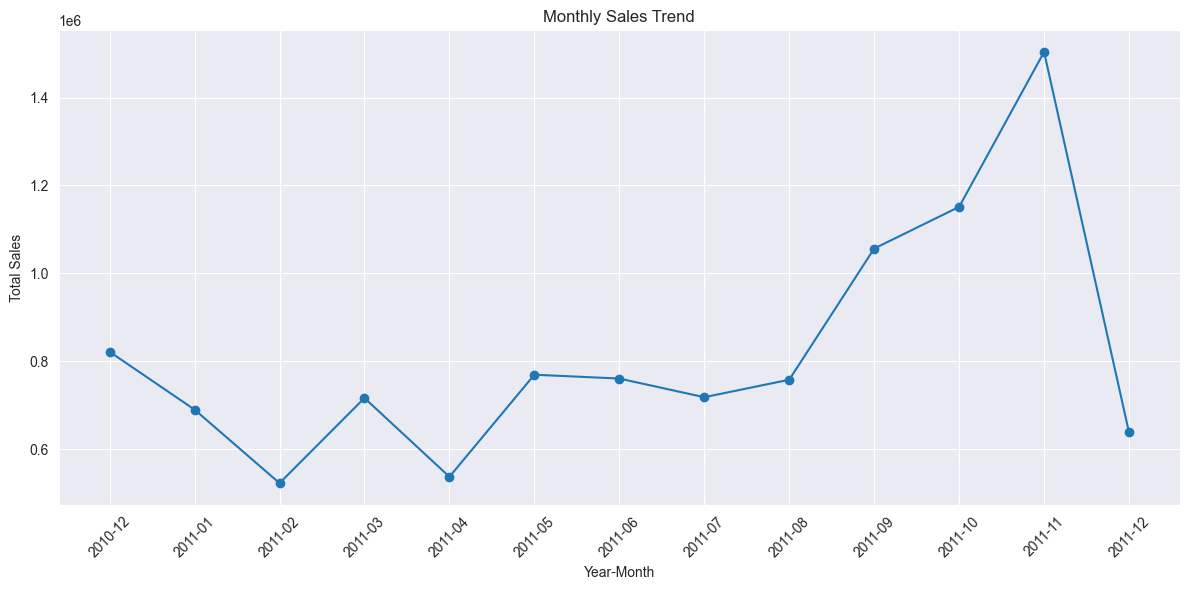

In [43]:
# Monthly Sales Trend
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('YearMonth')['TotalAmount'].sum().reset_index()
monthly_sales['YearMonth'] = monthly_sales['YearMonth'].astype(str)

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['YearMonth'], monthly_sales['TotalAmount'], marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

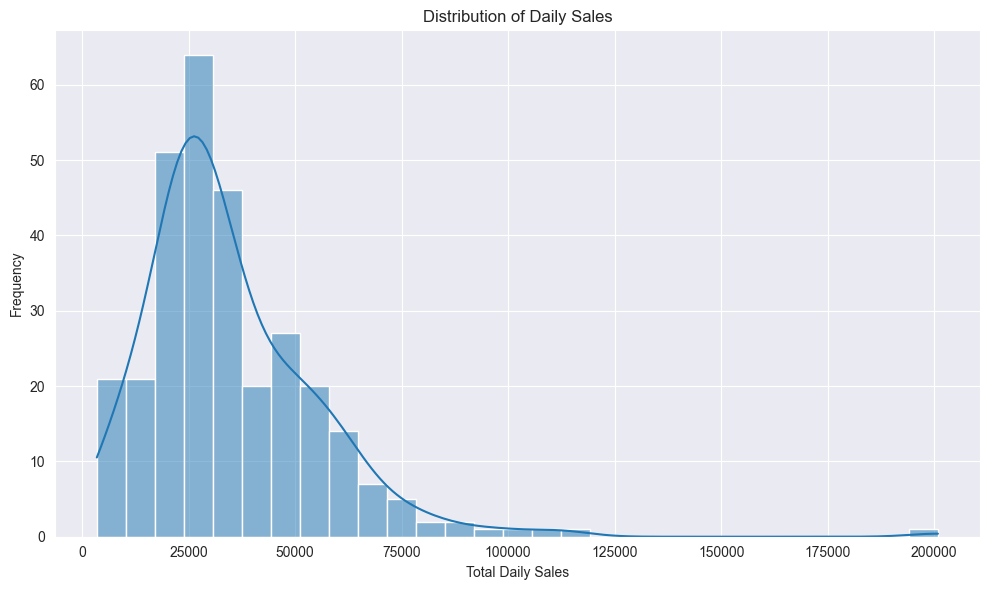

In [44]:
# Sales Distribution
plt.figure(figsize=(10, 6))
sns.histplot(daily_sales['TotalAmount'], kde=True)
plt.title('Distribution of Daily Sales')
plt.xlabel('Total Daily Sales')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

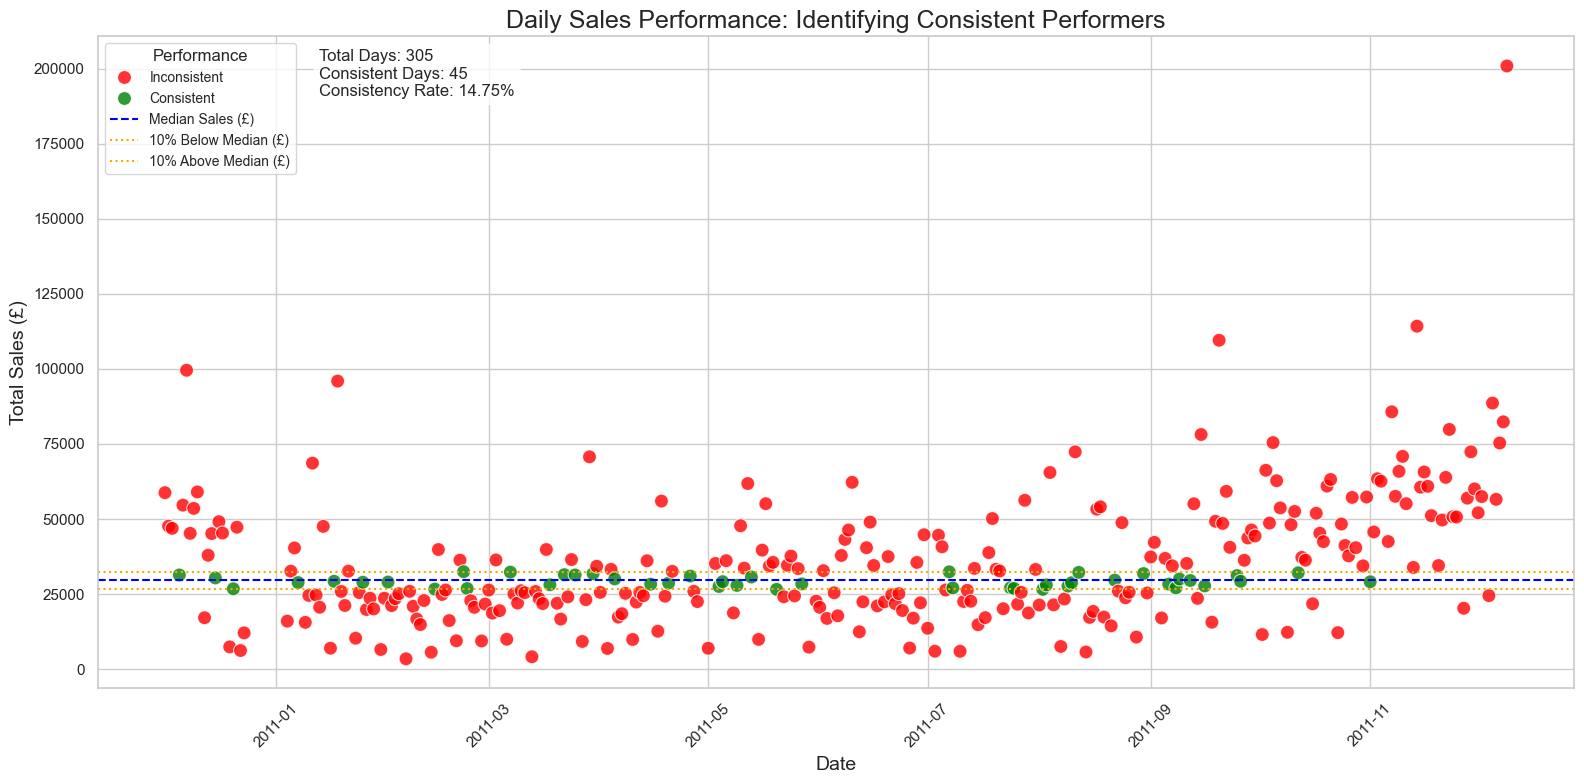


Consistent Performers Analysis:
Median Daily Sales: £29526.29
Lower Bound (90% of median): £26573.66
Upper Bound (110% of median): £32478.92
Number of Consistent Days: 45
Percentage of Consistent Days: 14.75%


In [45]:
# Consistent Performers

# Calculate median and consistent performers
median_sales = daily_sales['TotalAmount'].median()
lower_bound = median_sales * 0.9
upper_bound = median_sales * 1.1

# Create a new column to categorize days
daily_sales['Performance'] = np.where(
    (daily_sales['TotalAmount'] >= lower_bound) & (daily_sales['TotalAmount'] <= upper_bound),
    'Consistent',
    'Inconsistent'
)

# Create the scatter plot
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")  # Set the style for the plot

# Scatter plot with improved aesthetics
scatter = sns.scatterplot(data=daily_sales, x='Date', y='TotalAmount', hue='Performance', 
                          palette={'Consistent': 'green', 'Inconsistent': 'red'}, 
                          alpha=0.8, s=100, edgecolor='w')

# Add lines for median and bounds with annotations
plt.axhline(y=median_sales, color='blue', linestyle='--', label='Median Sales (£)')
plt.axhline(y=lower_bound, color='orange', linestyle=':', label='10% Below Median (£)')
plt.axhline(y=upper_bound, color='orange', linestyle=':', label='10% Above Median (£)')

# Customize the plot
plt.title('Daily Sales Performance: Identifying Consistent Performers', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales (£)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Performance', title_fontsize='12', fontsize='10')
plt.grid(True)

# Add text box with statistics
consistent_count = (daily_sales['Performance'] == 'Consistent').sum()
total_days = len(daily_sales)
consistent_percentage = (consistent_count / total_days) * 100

stats_text = f'Total Days: {total_days}\n'
stats_text += f'Consistent Days: {consistent_count}\n'
stats_text += f'Consistency Rate: {consistent_percentage:.2f}%'

plt.text(0.15, 0.98, stats_text, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print additional insights
print("\nConsistent Performers Analysis:")
print(f"Median Daily Sales: £{median_sales:.2f}")
print(f"Lower Bound (90% of median): £{lower_bound:.2f}")
print(f"Upper Bound (110% of median): £{upper_bound:.2f}")
print(f"Number of Consistent Days: {consistent_count}")
print(f"Percentage of Consistent Days: {consistent_percentage:.2f}%")

In [46]:
# Dashboard

In [47]:
import openpyxl

pip install dash pandas plotly openpyxl

SyntaxError: invalid syntax (2383720920.py, line 3)

In [31]:
import pandas as pd

# Load data from Excel file
file_path = 'Online Retail.xlsx'
sales_data = pd.read_excel(file_path, sheet_name='Online Retail')

# Data Preparation
# Drop rows with missing values in critical columns
sales_data.dropna(subset=['InvoiceNo', 'Quantity', 'UnitPrice', 'CustomerID'], inplace=True)

# Convert InvoiceDate to datetime format
sales_data['InvoiceDate'] = pd.to_datetime(sales_data['InvoiceDate'])

# Calculate TotalAmount
sales_data['TotalAmount'] = sales_data['Quantity'] * sales_data['UnitPrice']

# Optional: Remove negative quantities if they exist (returns)
sales_data = sales_data[sales_data['Quantity'] > 0]

# Display the first few rows of the dataset to verify preparation
print(sales_data.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalAmount  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom        15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom        22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34  


In [42]:
pip install pandas plotly ipywidgets openpyxl

Note: you may need to restart the kernel to use updated packages.


In [43]:
pip install dash dash-bootstrap-components pandas plotly openpyxl

Note: you may need to restart the kernel to use updated packages.


In [44]:
pip install dash dash-bootstrap-components pandas plotly openpyxl

Note: you may need to restart the kernel to use updated packages.


In [47]:
# Install necessary libraries
!pip install dash pandas plotly dash-bootstrap-components -q

# Import libraries
import dash
from dash import dcc, html, Input, Output
import dash_bootstrap_components as dbc
import pandas as pd
import plotly.graph_objects as go

# Load dataset
file_path = 'Online Retail.xlsx'
data = pd.read_excel(file_path)

# Add calculated columns
data['Revenue'] = data['Quantity'] * data['UnitPrice']
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Date'] = data['InvoiceDate'].dt.date
data['Month'] = data['InvoiceDate'].dt.to_period('M')

# Dash App
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.CYBORG])

app.layout = dbc.Container([
    # Header
    dbc.Row([
        dbc.Col(html.H1("Sales Dashboard", className="text-center text-white mb-4"), width=12)
    ]),

    # Filters
    dbc.Row([
        dbc.Col([
            html.Label("Select Country:", className="text-white"),
            dcc.Dropdown(
                id='country-filter',
                options=[{'label': 'All', 'value': 'All'}] + 
                        [{'label': country, 'value': country} for country in data['Country'].unique()],
                value='All',  # Default to "All"
                placeholder="All Countries",
                style={'color': 'black'}
            )
        ], width=4),

        dbc.Col([
            html.Label("Select Date Range:", className="text-white"),
            dcc.DatePickerRange(
                id='date-filter',
                start_date=data['Date'].min(),
                end_date=data['Date'].max(),
                display_format="YYYY-MM-DD",
                style={'color': 'black'}
            )
        ], width=4),
    ], className="mb-4"),

    # KPI Cards
    dbc.Row([
        dbc.Col(dbc.Card([
            dbc.CardBody([
                html.H4("Total Revenue", className="text-center text-primary"),
                html.H2(id="total-revenue", className="text-center text-white")
            ])
        ], color="dark", outline=True), width=4),

        dbc.Col(dbc.Card([
            dbc.CardBody([
                html.H4("Total Orders", className="text-center text-primary"),
                html.H2(id="total-orders", className="text-center text-white")
            ])
        ], color="dark", outline=True), width=4),

        dbc.Col(dbc.Card([
            dbc.CardBody([
                html.H4("Unique Customers", className="text-center text-primary"),
                html.H2(id="total-customers", className="text-center text-white")
            ])
        ], color="dark", outline=True), width=4),
    ], className="mb-4"),

    # Pyramid Plot
    dbc.Row([
        dbc.Col(dcc.Graph(id="product-performance-chart"), width=12)
    ], className="mb-4"),

    # Daily Sales Trends and Customer Segmentation (Side by Side)
    dbc.Row([
        dbc.Col(dcc.Graph(id="daily-sales-trends-chart"), width=6),
        dbc.Col(dcc.Graph(id="customer-segmentation-chart"), width=6),
    ], className="mb-4"),

    # Quantity Movement Chart (Standalone)
    dbc.Row([
        dbc.Col(dcc.Graph(id="quantity-movement-chart"), width=12)
    ], className="mb-4"),

    # Pareto Chart
    dbc.Row([
        dbc.Col(dcc.Graph(id="pareto-chart"), width=12)
    ], className="mb-4"),
])

# Callbacks
@app.callback(
    [
        Output("total-revenue", "children"),
        Output("total-orders", "children"),
        Output("total-customers", "children"),
        Output("daily-sales-trends-chart", "figure"),
        Output("customer-segmentation-chart", "figure"),
        Output("quantity-movement-chart", "figure"),
        Output("product-performance-chart", "figure"),  # Pyramid plot
        Output("pareto-chart", "figure")  # Pareto Chart
    ],
    [Input("country-filter", "value"), Input("date-filter", "start_date"), Input("date-filter", "end_date")]
)
def update_dashboard(selected_country, start_date, end_date):
    # Filter and preprocess the data
    if not start_date:
        start_date = data['InvoiceDate'].min()
    if not end_date:
        end_date = data['InvoiceDate'].max()

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    filtered_data = data[
        (data['InvoiceDate'] >= start_date) &
        (data['InvoiceDate'] <= end_date)
    ]
    
    if selected_country and selected_country != 'All':
        filtered_data = filtered_data[filtered_data['Country'] == selected_country]
    
    # Handle empty dataset
    if filtered_data.empty:
        empty_fig = go.Figure().update_layout(title="No Data Available")
        return "$0", "0", "0", empty_fig, empty_fig, empty_fig, empty_fig, empty_fig

    # KPIs
    total_revenue = f"${filtered_data['Revenue'].sum():,.0f}"
    total_orders = f"{filtered_data['InvoiceNo'].nunique()}"
    total_customers = f"{filtered_data['CustomerID'].nunique()}"

    # Daily Sales Trends
    daily_sales_data = filtered_data.groupby('Date')['Revenue'].sum().reset_index()
    daily_sales_fig = px.line(
        daily_sales_data, 
        x='Date', 
        y='Revenue', 
        title="Daily Sales Trends"
    )
    daily_sales_fig.update_layout(
        paper_bgcolor='rgba(0,0,0,0)', 
        plot_bgcolor='rgba(0,0,0,0)', 
        title_font_color='white',
        xaxis=dict(title="Date", color='white'),
        yaxis=dict(title="Revenue", color='white')
    )

    # Customer Segmentation
    customer_data = filtered_data.groupby('CustomerID').agg({'InvoiceNo': 'count', 'Revenue': 'sum'}).reset_index()
    customer_fig = px.scatter(
        customer_data, 
        x='InvoiceNo', 
        y='Revenue', 
        hover_data=['CustomerID'], 
        title="Customer Segmentation"
    )
    customer_fig.update_layout(
        paper_bgcolor='rgba(0,0,0,0)', 
        plot_bgcolor='rgba(0,0,0,0)', 
        title_font_color='white',
        xaxis=dict(title="Number of Orders", color='white'),
        yaxis=dict(title="Revenue", color='white')
    )

    # Quantity Movement Chart
    filtered_data['Month'] = filtered_data['InvoiceDate'].dt.strftime('%B')  # Extract month name
    quantity_data = filtered_data.groupby(['Month', 'Description'])['Quantity'].sum().reset_index()

    # Sort months chronologically
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    quantity_data['Month'] = pd.Categorical(quantity_data['Month'], categories=month_order, ordered=True)
    quantity_data = quantity_data.sort_values('Month')

    # Top 5 Products by Total Quantity
    top_products = (
        quantity_data.groupby('Description')['Quantity'].sum()
        .nlargest(5).index
    )
    quantity_data = quantity_data[quantity_data['Description'].isin(top_products)]

    quantity_fig = px.line(
        quantity_data, 
        x='Month', 
        y='Quantity', 
        color='Description', 
        title="Quantity Movement by Month for Top 5 Products"
    )
    quantity_fig.update_layout(
        paper_bgcolor='rgba(0,0,0,0)', 
        plot_bgcolor='rgba(0,0,0,0)', 
        title_font_color='white', 
        xaxis=dict(title="Month", color='white'),
        yaxis=dict(title="Quantity Sold", color='white'),
        legend=dict(font=dict(color="white"))
    )

    # Pyramid Plot for Top 10 Products by Revenue and Order Frequency
    top_revenue_products = (
        filtered_data.groupby('Description')['Revenue'].sum()
        .sort_values(ascending=False)
        .head(10)
    )

    top_order_products = (
        filtered_data.groupby('Description')['InvoiceNo'].nunique()
        .sort_values(ascending=False)
        .head(10)
    )

    # Normalize Order Frequency to Revenue Range
    max_revenue = top_revenue_products.max()
    max_orders = top_order_products.max()
    normalized_orders = top_order_products * (max_revenue / max_orders)

    # Create Pyramid Plot
    pyramid_fig = go.Figure()

    # Revenue Bar (Right Side)
    pyramid_fig.add_trace(go.Bar(
        x=top_revenue_products.values,
        y=top_revenue_products.index,
        orientation='h',
        name='Revenue',
        marker=dict(color='blue'),
        hovertemplate='%{y}: $%{x:,.2f}<extra></extra>'
    ))

    # Normalized Order Frequency Bar (Left Side)
    pyramid_fig.add_trace(go.Bar(
        x=-normalized_orders.values,
        y=normalized_orders.index,
        orientation='h',
        name='Order Frequency',
        customdata=top_order_products.values,
        hovertemplate='%{y}: %{customdata}<extra></extra>'
    ))

    # Update Layout for Pyramid
    pyramid_fig.update_layout(
        title="Top 10 Products by Revenue and Order Frequency",
        xaxis=dict(
            title="Values",
            tickvals=[-max_revenue, -max_revenue / 2, 0, max_revenue / 2, max_revenue],
            ticktext=[
                f"{int(max_orders):,} Orders",
                f"{int(max_orders / 2):,} Orders",
                "0",
                f"${int(max_revenue / 2):,}",
                f"${int(max_revenue):,}"
            ],
            color='white'
        ),
        yaxis=dict(title="Products", color='white'),
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        title_font_color='white',
        font=dict(color='white'),
        barmode='relative'
    )

    # Pareto Chart for Top 20 Contributors by Revenue
    top_20_contributors = (
        filtered_data.groupby('Description')['Revenue']
        .sum()
        .sort_values(ascending=False)
        .head(20)
        .reset_index()
    )
    top_20_contributors['Cumulative %'] = (
        top_20_contributors['Revenue'].cumsum() / top_20_contributors['Revenue'].sum() * 100
    )

    # Truncate long product descriptions for X-axis
    top_20_contributors['Short Description'] = top_20_contributors['Description'].str.slice(0, 15) + "..."

    pareto_fig = go.Figure()

    # Add Revenue Bars
    pareto_fig.add_trace(go.Bar(
        x=top_20_contributors['Short Description'],
        y=top_20_contributors['Revenue'],
        name='Revenue',
        marker=dict(color='hotpink'),
        hovertemplate='%{x}<br>Full Name: %{customdata}<br>Revenue: $%{y:,.2f}<extra></extra>',
        customdata=top_20_contributors['Description']  # Full product descriptions for hover
    ))

    # Add Cumulative Percentage Line
    pareto_fig.add_trace(go.Scatter(
        x=top_20_contributors['Short Description'],
        y=top_20_contributors['Cumulative %'],
        name='Cumulative %',
        mode='lines+markers',
        marker=dict(color='yellow', size=6), 
        line=dict(color='yellow', width=2, dash='solid'),
        hovertemplate='%{x}: %{y:.1f}%<extra></extra>',
        yaxis='y2'  # Specify the secondary Y-axis
    ))

    # Annotate Cumulative Percentage (Every 5th Point)
    for i, txt in enumerate(top_20_contributors['Cumulative %']):
        if i % 5 == 0:  # Add annotations only for every 5th point
            pareto_fig.add_annotation(
                x=top_20_contributors['Short Description'][i],
                y=txt + 5,  
                text=f'{txt:.1f}%',
                showarrow=False,
                font=dict(size=12, color='white'),  # Larger font size and contrasting color
                align='center',
                yref='y2'  # Use secondary Y-axis for annotations
            )

    # Update Layout for Pareto Chart
    pareto_fig.update_layout(
        title="Pareto Chart: Revenue Contribution of Top 20 Products",
        xaxis=dict(
            title="Product Description",
            color='white',
            tickangle=-45,  # Rotate X-axis labels vertically
            tickfont=dict(size=10) 
        ),
        yaxis=dict(
            title="Revenue",
            color='hotpink',
            showgrid=True
        ),
        yaxis2=dict(
            title="Cumulative %",
            titlefont=dict(color='yellow'),
            overlaying='y',
            side='right',
            tickfont=dict(color='yellow'),
            range=[0, 100],  # Ensure the secondary Y-axis is scaled between 0 and 100%
            showgrid=False
        ),
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        title_font_color='white',
        font=dict(color='white'),
        legend=dict(
            font=dict(color='white'),
            orientation='h',  # Horizontal legend
            x=0.5,  # Center the legend horizontally
            xanchor='center',
            y=-0.4  # Move legend below the chart
        ),
        margin=dict(
            b=200,  # Add space at the bottom for long X-axis labels
            t=50,   # Reduce top margin
            r=50    # Add space for Y-axis2 labels
        )
    )
    return total_revenue, total_orders, total_customers, daily_sales_fig, customer_fig, quantity_fig, pyramid_fig, pareto_fig


# Run the app
if __name__ == '__main__':
    app.run_server(port=8052, debug=True)
    
    
import webbrowser
webbrowser.open('http://127.0.0.1:8052/')



True